## GLM,  fixed versus random effects in fMRI

### Plan

1. Remind what is the issue with random and fixed effects
2. Construct some data set from one bold series
    1. Extract a time series   
    2. Add some signal (3 conditions)
3. Solve the GLM for one subject
4. Solve the GLM for 7 subjects
    1. Fixed
    2. Random
5. Testing. What is the distribution of our contrast of beta values ?

In [15]:
# - 
from __future__ import print_function, division
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# - set gray colormap and nearest neighbor interpolation by default
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'

# - import numpy.linalg with a shorter name
import numpy.linalg as npl

In [16]:
# - 
np.set_printoptions(precision=3)

### 1. The issue with random and fixed effect

See http://www.fil.ion.ucl.ac.uk/spm/doc/books/hbf2/pdfs/Ch12.pdf

### 2. Construct some data from a BOLD time series

In [17]:
# - nibabel
import nibabel as nib

In [18]:
# - change this to the path of this image on your system
my_path_to_file = "/home/jb/code/pna2015/pna2015/day10/ds114_sub009_t2r1.nii"

(64, 64, 30, 173)


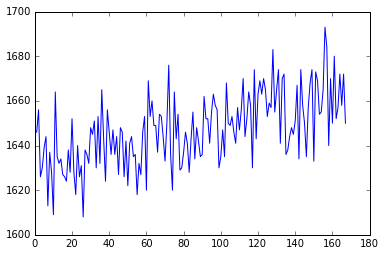

In [19]:
# load this image, get the 32,32,15 voxel time series without the 5 first points.
# plot the time course
to_rm = 5
img = nib.load(my_path_to_file)
print(img.shape)
(x,y,z) = (32,32,15)
plt.plot(img.get_data()[x,y,z,to_rm:])


In [20]:
# - store the previous time series at the x,y,z voxel in 'bold'
# compute bold mean and std
bold = np.asarray(img.get_data()[x,y,z,to_rm:])
bold_std = bold.std()
bold_mean = bold.mean()
print(bold_std, bold_mean)


15.9044132678 1647.08928571


In [21]:
# - Normalized to have mean 100
bold = bold * 100. / bold_mean
bold_std = bold.std()
bold_mean = bold.mean()
sig_mag = 2*bold_std
print(bold_std, bold_mean, sig_mag)

0.965607232455 100.0 1.93121446491


(42, 3)


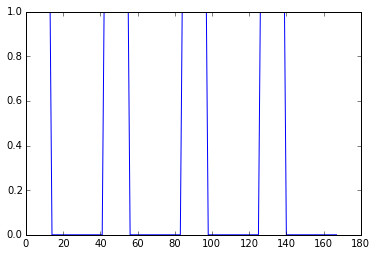

In [22]:
# - divide the total duration time in 12, into 12 intervals of "cond_duration" TR
# we will fill the time with 3 conditions, (eg A,B,C)
# A, B will be our experimental conditions, C is for control condition (baseline)

cond_duration = bold.shape[0] // 12 # integer division

# make a signal for two conditions: A, B. Each block of A or B lasts for cond_duration, 
# and these blocks occur regularely, eg if the time is divided in 12 intervals,
# 'A' blocks will occur at intervals 0, 3, 6, 9, 'B' at intervals 1, 4, 7, 10, and the 
# remaining intervals will be baseline 

ones = np.ones((cond_duration,1))
a = np.kron(np.eye(3), ones) 

print(a.shape)
signal_A = np.kron(np.ones(4), a[:,0]).flatten()
signal_B = np.kron(np.ones(4), a[:,1]).flatten()
baseline = np.ones(shape=(bold.shape[0]))
plt.plot(signal_A)

(168, 3)


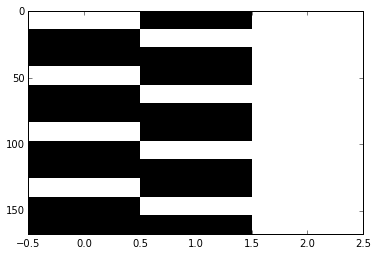

In [23]:
# - construct the design matrix with condition A, B and baseline using np.vstack
X_ = np.vstack((signal_A, signal_B, baseline)).T
plt.imshow(X_,aspect='auto',interpolation='nearest')
print(X_.shape)

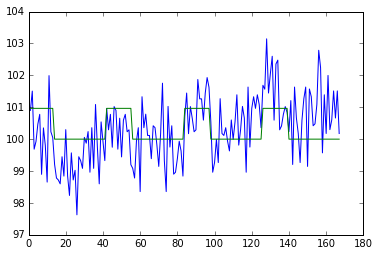

In [24]:
# - add some signal with a signal to noise ratio of 2, 
# sig_mag = 1.0*bold_std

sig_mag = 1.0
c = [sig_mag*bold_std, 0, 0]
Y = X_.dot(c) + bold
time = np.arange(X_.shape[0])
plt.plot(time, Y, time, X_.dot(c)+100.)

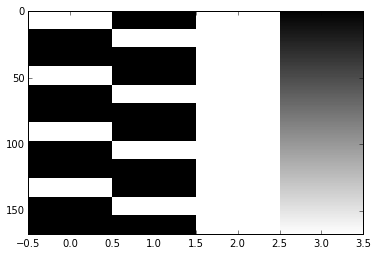

In [25]:
# Add a trend to X_, call this new matrix X
trend = np.arange(X_.shape[0])[:,np.newaxis]/X_.shape[0]
X = np.hstack((X_, trend))
plt.imshow(X,aspect='auto',interpolation='nearest')


### Now, recall the GLM and how to test a contrast 

Looking again at our time series, we should add a trend...

In [26]:
# - estimate the parameters of the model X_ and X using the OLS (see below)

pinvX_ = npl.inv(X_.T.dot(X_)).dot(X_.T) # this is to match the formula we have seen, 
pinvX = npl.inv(X.T.dot(X)).dot(X.T) # in practice do not use this, use npl.pinv(X2)

beta_ = pinvX_.dot(Y)
beta = pinvX.dot(Y)
print(beta_, beta)

[   0.51    -0.4    100.285] [  0.825  -0.243  99.189   1.89 ]


We note our estimates 'beta' $\hat{\beta}_1$, $\hat{\beta}_2$, $\hat{\beta}_3$, etc

### Now, we need to _test_ if our signal of interest $\hat{\beta}_1$ is significant

We will need 2 things: signal, and standard error of the signal.

#### First, what is our observed signal of interest ?

In [27]:
# express our signal of interest as c.dot(beta) - print the signal magnitude. 
c = np.asarray([1,0,0,0]).reshape(4,1)
signal = c.T.dot(beta[:,np.newaxis])[0,0]
print(signal)

0.825176582124


#### Second, what is our observed standard error ?

Recall the linear model for one observation i :

$$ Y_i = X \beta + \epsilon_i $$

and in matrix form:

$$ Y = X \beta + \epsilon $$

with $ \epsilon_i $ independant gaussian variable with variance $\sigma^2$, such that the vector $\epsilon$ has variance $\sigma^2 I$,  $I$ the identity matrix.

Our OLS estimates are:

$$ \hat\beta = (X^tX)^{-1}X^t Y $$

Our fitted data : 

$$ \hat{Y} =  X\hat\beta = X(X^tX)^{-1}X^t Y = M_X Y$$

And our residuals:

$$ r = \hat{\epsilon} = Y - \hat{Y} = Y - M_X Y  = (I - M_X) Y = R_X Y $$

$R_X$ or $R$  when there is no ambiguity, is the __residual forming__ matrix. 


Let's now  compute $ \mathrm{var}(c^T \hat\beta) $. We have

$$ \mathrm{var}(c^T \hat\beta) = \mathrm{var}(c^T (X^tX)^{-1}X^t Y) \qquad  (A)  $$ 

Let's call $ X^+ = (X^tX)^{-1}X^t $.

We have assumed that $\mathrm{var}(Y) = \sigma^2 I$
with $I$ the identity matrix.

$$ (A) \;\; = c^T X^+ \mathrm{var}(Y) X^{+T} c  = \sigma^2 c^T X^+ X^{+T} c = \sigma^2 c^T (X^T X)^- c $$ 



#### How do we know $\sigma$ ? We don't, we have to estimate it. 

First, we will need the residual sum of square:

Our residuals, the estimated noise, are $ r = \hat{\epsilon} = Y - \hat{Y} $, with $ \hat{Y} = X \hat{\beta}$

The residual sum of squre is :

$$ \textrm{RSS} = \sum_{i=1}^{n} (Y_i - \widehat{Y_i})^2 $$

But the mean sum of square is not the simple division by the number of time points, we have to correct for the number of estimation we have done when computing $\widehat{Y}$, so that will be 

$$\hat\sigma^2 = \textrm{RSS} / (n - p)$$

Where p here is 4, and n = 196.

This estimation is also called the **Mean Residual Sum of Square** (MRSS), and $\hat\sigma = \textrm{MRSS} = \textrm{RSS} / \it{df} $  where $\it{df}$ is the degrees of freedom $(n-p) = 196 - 4$, the number of observations (here, 196) minus the rank of the design matrix (ie the number of independant columns, here 4). The MRSS is the estimation of our noise level.

Coming back to our t-statistics, we can now calculate the **Standard Error** (SE) of $c^T \hat\beta$ with $\textrm{SE} = \sqrt{\hat{\sigma}^2 c^T (X^t X)^+ c} $

The t test is then : $t = {c^T \hat\beta}/{\textrm{SE}} $


In [28]:
# - Compute the estimate of sigma: compute the residuals, take the sum of square, and 
# divide by n-p, 
# n is the number of observations, p is the number of (free) parameters that we estimate

n,p = X.shape # ok because X has no linear dependencies for its columns !
r = Y - X.dot(beta)
RSS = (r**2).sum()
sigma2_hat = RSS/(n - p)

print(RSS, sigma2_hat)

102.523017949 0.625140353349


In [29]:
# - what can you say of this compared to bold_std ? 
# Compute the standard error of the signal

V_1 = npl.inv(X.T.dot(X))

SE = np.sqrt( sigma2_hat * c.T.dot(V_1).dot(c))[0,0]
print(V_1, "\n", SE)


[[ 0.038  0.019 -0.025  0.013]
 [ 0.019  0.036 -0.022  0.006]
 [-0.025 -0.022  0.043 -0.044]
 [ 0.013  0.006 -0.044  0.076]] 
 0.153752432606


In [30]:
# - compute the t statistics, that follows a student distribution with n-p df

t_observed = signal/SE
print(t_observed)

5.36691724573


In [31]:
# - 
signal, sigma2_hat, SE

(0.82517658212413614, 0.62514035334885676, 0.15375243260563373)

#### How far from the t distribution centered on 0 ?

In [32]:
# - 
import scipy.stats as sst

In [33]:
# compute the p of the t statistics, use sst.t(df) to define a t_variable
# then find how to compute the p-value (see cdf or sf functions of t)
df = n-p
t_variable = sst.t(df)
p_ttest = t_variable.sf(t_observed)
print(p_ttest)

1.34762696233e-07


###  F statistics and model selection

#### Review the F test

The F-test is best understood in terms of model selection.
The question we are asking is : should all the regressor be in the model ? 

To answer this, we construct a reduced model X0 from X. From this model we look at the RSS of model X (full model) and model X0 (reduced). The residuals are always going to be larger for the reduced model (how do we prove this ? Let's see in class). 

$$
\begin{eqnarray} 
F_{\nu_1, \nu_2} & = & \frac{(\hat\epsilon_0^t \hat\epsilon_0 - \hat\epsilon^T\hat\epsilon)/ \nu_{1} }{\hat\epsilon^T\hat\epsilon/\nu_{2}} \\ 
 & = & \frac{(Y^TR_{X_0}Y - Y^TR_{X}Y)/ \nu_{1} }{Y^TR_{X}Y/\nu_{2}} \\ 
 & = & \frac{(Y^T(I-P_{X_0})Y - Y^T(I-P_{X})Y)/ \nu_{1} }{Y^T(I- P_{X})Y/\nu_{2}} \\ 
& = & \frac{(\textrm{SSR}(X_0) - \textrm{SSR}(X))/\nu_1}{\textrm{SSR}(X)/\nu_2}
\end{eqnarray}
$$

What are $\nu_{1}$ and $\nu_{2}$ ?

They are the same things that we had for the t-test. The difference $ \hat\epsilon_0^t \hat\epsilon_0 - \hat\epsilon^T\hat\epsilon $ will have the difference of each term df. 

#### Let's apply it in our simple case :

In [34]:
# compute the F test for regressor 0 in our previous model
# what is the difference with the t-test

X0 = X[:,1:]
# plt.imshow(X0, aspect='auto')


In [35]:
# -  define a glm function that returns beta, Yfitted, residuals

def glm(X, Y):
    """ a simple GLM function returning the estimated parameters and residuals 
    
    parameters:
    -----------
    X: np array
        The desing matrix
    Y: np array
        The data
    
    returns:
    --------
    betah : np array
            estimated beta
    Yfitted: np array
            fitted data 
    resid:  np array
            residuals
    """
    
    betah   =  npl.pinv(X).dot(Y)
    Yfitted =  X.dot(betah)
    resid   =  Y - Yfitted
    return betah, Yfitted, resid


# define an F test function:

def F_test(X, X0, Y):
    """
    parameters:
    -----------
    X: np array
        The design matrix
    X0: np array
        The reduced design matrix
    Y: np array
        The data
        
    returns
    --------
    F: float
        the F statistics
    nu1, nu2: floats
        the degrees of freedom
    """
    betah, Yfitted, resid = glm(X,Y)
    betah0, Yfitted0, resid0 = glm(X0,Y)
    
    nu1 = X.shape[1] - X0.shape[1] # assume X full rank (no linear dependencies)
    nu2 = X.shape[0] - X.shape[1]

    numerator = ((resid0**2).sum() - (resid**2).sum())/nu1 
    denominator = (resid**2).sum()/nu2
    F =  numerator / denominator
    return F, nu1, nu2

# define a t test function:

def t_test(X, c, Y):
    """
    """
    assert c.ndim == 2
    assert c.shape[1] == 1
    betah   =  npl.pinv(X).dot(Y)
    signal = c.T.dot(betah)[0,0]
    RSS   =  ((Y - X.dot(betah))**2).sum()
    p = npl.matrix_rank(X)
    n = X.shape[0]
    df = n-p
    V_1 = npl.pinv(X.T.dot(X))
    SE = np.sqrt( (RSS/df) * c.T.dot(V_1).dot(c))[0,0]
    return signal/SE, df 
    

In [36]:
# compute the F test for regressor 0 in our previous model 
# use the F_test function
# use sst.f to find the p value, compare it to the p_ttest
# why is p_ttest half of the p_Ftest ?

f_obs, nu1, nu2 = F_test(X, X0, Y)
print(f_obs, nu1, nu2)

F_variable = sst.f(nu1, nu2)
p_Ftest = F_variable.sf(f_obs)

print(p_Ftest, p_ttest*2)

28.8038007225 1 164
2.69525392467e-07 2.69525392466e-07


In [37]:
# - F test can be computed by stacking several one dimensional contrasts 
# into a "contrasts matrix" - no demonstration provided here but see reference
# Poline and Brett, Neuroimage 2012.

In [38]:
# - now, test A and B :
X0 = X[:,2:]
f_obs, nu1, nu2 = F_test(X, X0, Y)

F_variable = sst.f(nu1, nu2)
p_FtestAB = F_variable.sf(f_obs)

print(p_FtestAB, p_Ftest)
# is this expected ?

6.19458741707e-11 2.69525392467e-07


### Let's create  5 subjects with the same design

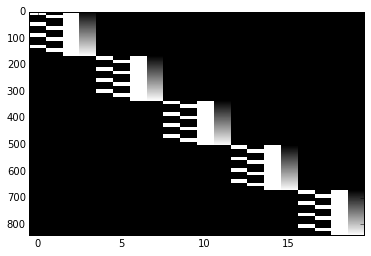

In [39]:
# - 
N = 5
XN = np.kron(np.eye(N), X)
plt.imshow(XN, aspect='auto',interpolation='nearest')

In [40]:
# - create N subject data, add noise to the previous data
YN = np.kron(np.ones(N), Y)[:,np.newaxis]
YN += np.random.normal(0, 0.7, size=YN.shape)

In [41]:
# - create contrast
c = np.asarray([1,0,0,0]).reshape(4,1)
cN = np.kron(np.ones(shape=(1,N)), c.T).T
cN.shape

(20, 1)

In [42]:
# - compute t stat for fixed effect analysis
t_Nfix, df = t_test(XN, cN, YN)
print(t_Nfix, df, sst.t.sf(t_Nfix, df)*2)

7.20941620009 820 1.27693693883e-12


### Create a random effect model:

In [43]:
# compute signal (c.T.dot(beta)) for each subject
signals = np.zeros((N,))
nTR = Y.shape[0]
pinvX = npl.pinv(X)

for sub in range(N):
    Y_sub = YN[sub*nTR:(sub+1)*nTR]
    signals[sub] = c.T.dot(pinvX.dot(Y_sub))

# print the signals
print(signals)

[ 0.424  0.739  0.771  0.691  0.631]


In [44]:
# What is the random effect t-test ? Create a design matrix and a contrast, use t_test()
X_random = np.ones((N,1))
c_random = np.ones((1,1))
t_random, df_random = t_test(X_random, c_random, signals.reshape(N,1))
print(t_random, df_random, sst.t.sf(t_random, df_random)*2)

10.5857974999 4 0.000450662649435


In [45]:
# - check that we get same between t_test and scipy stat ttest_1samp
sst.ttest_1samp(signals, 0)

(10.585797499881789, 0.00045066264943452163)

#### Compare the two statistics: which one is "better"  ?